<left><img width=25% src="../slides/img/cornell_tech2.svg"></left>

# Lecture 16: Boosting

In this lecture, we will cover a new class of machine learning algorithms based on an idea called **Boosting**.
Boosting is an effective way to combine the predictions from simple models into more complex and powerful ones that often attain state-of-the-art performance on many machine learning competitions and benchmarks.

# 16.1. Defining Boosting

We will begin by defining boosting and seeing how this concept relates to our previous lectures about bagging, which we saw in the context of random forests and decision trees.

#### Review: Overfitting

Recall that we saw in our lecture on decision trees and random forests that a common machine learning failure mode is that of overfitting:

* A very expressive model (e.g., a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset and doesn't generalize.

#### Review: Bagging

The idea of *bagging* was to reduce *overfitting* by averaging many models trained on random subsets of the data.

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(y_test)
```

## 16.1.1. Underfitting and Boosting

Underfitting is another common problem in machine learning that can be thought of as the converse to _overfitting_.
* The model is too simple to fit the data well (e.g., approximating a high degree polynomial with linear regression).
* As a result, the model is not accurate on training data and is not accurate on new data.

#### Boosting

The idea of *boosting* is to reduce *underfitting* by combining models that correct each others' errors.

* As in bagging, we combine many models $g_t$ into one *ensemble* $f$.

* Unlike bagging, the $g_t$ are small and tend to underfit.

* Each $g_t$ fits the points where the previous models made errors.

#### Weak Learners

A key ingredient of a boosting algorithm is a *weak learner*.

* Intuitively, this is a model that is slightly better than random.
* Examples of weak learners include: small linear models, small decision trees (e.g., depth 1 or 2).

# 16.2. Structure of a Boosting Algorithm
Let's now move towards more fully describing the structure of a boosting algorithm.

**Step 1:** Fit a weak learner $g_0$ on dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$. Let $f=g_0$.

**Step 2:** Compute weights $w^{(i)}$ for each $i$ based on model predictions $f(x^{(i)})$ and targets $y^{(i)}$.
Give more weight to points with errors.

**Step 3:** Fit another weak learner $g_1$ on $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$ with weights $w^{(i)}$, which place more emphasis on the points on which the existing model is less accurate.

**Step 4:** Set $f_1 = g_0 + \alpha_1 g$ for some weight $\alpha_1$. Go to Step 2 and repeat.

At each step, $f_t$ becomes more expressive since it is the sum of a larger number of weak learners that are each accurate on a different subset of the data.

In Python-like pseudocode, this looks as follows:

```python
weights, ensemble = np.ones(n_data,), Ensemble([])
for i in range(n_models):
    model = SimpleBaseModel().fit(X, y, weights)
    predictions = ensemble.predict(X)
    model_weight, weights = update_weights(weights, predictions)
    ensemble.add(model, model_weight)

# output consensus prediction at test time:
y_test = ensemble.predict(y_test)
```

# 16.3. Adaboost

Given its historical importance, we begin with an introduction of Adaboost and use it to further illustrate the structure of boosting algorithms in general.

* __Type__: Supervised learning (classification).
* __Model family__: Ensembles of weak learners (often decision trees).
* __Objective function__: Exponential loss.
* __Optimizer__: Forward stagewise additive model building (to be defined in more detail below).

An interesting historical note, boosting algorithms were initially developed in the 90s within theoretical machine learning.

* Originally, boosting addressed a theoretical question of whether weak learners with >50% accuracy can be combined to form a strong learner.
* Eventually, this research led to a practical algorithm called *Adaboost*.

Today, there exist many algorithms that are considered types of boosting, even though they're not derived from the perspective of theoretical ML.

## 16.3.1. Defining Adaboost

We start with uniform weights $w^{(i)} = 1/n$ and $f = 0$. Then for $t=1,2,...,T$:

**Step 1:** Fit weak learner $g_t$ on $\mathcal{D}$ with weights $w^{(i)}$.

**Step 2:** Compute misclassification error
$$e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq g_t(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}}$$

* Recall that $\mathbb{I}\{\cdot\}$ is an indicator function that takes on value 1 when the condition in the brackets is true and 0 otherwise.
 
* Notice that if all the weights $w^{(i)}$ are the same, then this is just the misclassification rate.
When each weight can be different, we get a "weighted" misclassification error.

**Step 3:** Compute model weight and update function.

$$\alpha_t = \log[(1-e_t)/e_t]$$
$$f \gets f + \alpha_t g_t$$


* Notice that $e_t$ intuitively measures how much *influence* $g_t$ should have on our overall predictor $f$.
As $e_t$ approaches zero, meaning few of the highly weighted points were misclassified by $g_t$, $\alpha_t$ will be large, allowing $g_t$ to have a bigger contribution to our predictor.
As $e_t$ approaches 1/2 (recall that $g_t$'s are 'weak learners'), this means that $g_t$ is not doing much better than random guessing.
This will cause $\alpha_t$ to be close to zero, meaning that $g_t$ is contributing little to our overall prediction function.

**Step 4:** Compute new data weights $w^{(i)} \gets w^{(i)}\exp[\alpha_t \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\} ]$.

* Exponentiation ensures that all the weights are positive.
* If our predictor correctly classifies a point, its weight $w^{(i)}$ does not change.
* Any point that is misclassified by $f$ has its weight increased.
* We again use $\alpha_t$ here, as above, to mediate how strongly we adjust weights.

## 16.3.2. Adaboost: An Example

Let's implement Adaboost on a simple dataset to see what it can do.

Let's start by creating a classification dataset.
We will intentionally create a 2D dataset where the classes are not easily separable.

In [1]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
import numpy as np
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

We can visualize this dataset using `matplotlib`.

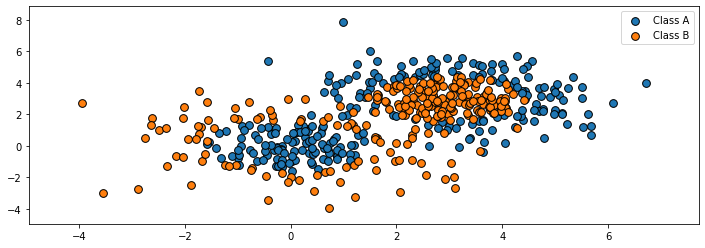

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# Plot the training points
plot_colors, plot_step, class_names = "br", 0.02, "AB"
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right');

Let's now train Adaboost on this dataset.
We use the `AdaBoostClassifier` class from `sklearn`.

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

Visualizing the output of the algorithm, we see that it can learn a highly non-linear decision boundary to separate the two classes.

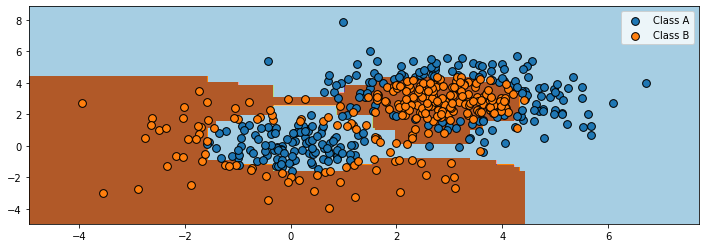

In [4]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

# plot decision boundary
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# plot training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right');

# 16.4. Ensembling

Boosting and bagging are special cases of *ensembling*.

The idea of ensembling is to combine many models into one. Bagging and boosting are ensembling techniques to reduce over- and under-fitting, respectively.

There are other approaches to ensembling that are useful to know about.
* In stacking, we train $m$ independent models $g_j(x)$ (possibly from different model classes) and then train another model $f(x)$ to predict $y$ from the outputs of $g_j$.
* The Bayesian approach can also be seen as form of ensembling
$$P(y\mid x) = \int_\theta P(y\mid x,\theta) P(\theta \mid \mathcal{D}) d\theta$$
where we average models $P(y\mid x,\theta)$ using weights $P(\theta \mid \mathcal{D})$.

Ensembling is a useful technique in machine learning, as it often helps squeeze out additional performance out of ML algorithms, however this comes at the cost of additional (potentially quite expensive) computation to train and use ensembles.

As we have seen with Adaboost, boosting algorithms are a form of ensembling that yield high accuracy via a highly expressive non-linear model family. If trees are used as weak learners, then we also have the added benefit of requiring little to no preprocessing. However, as we saw with the random forest algorithm, with boosting, the interpretability of the weak learners is lost.

## 16.4.1. Bagging vs. Boosting
We conclude this initial introduction to boosting by contrasting it to the bagging approach we saw previously.
While both concepts refer to methods for combining the outputs of various models trained on the same dataset, there are important distinctions between these concepts.
* Bagging targets **overfitting** vs. boosting targets **underfitting**.
* Bagging is a **parallelizable** method for combining models (e.g., each tree in the random forest can be learned in parallel) vs. boosting is an inherently **sequential** way to combine models.

# 16.5. Additive Models

Next, we are going to see another perspective on boosting and derive new boosting algorithms.

Boosting can be seen as a way of fitting more general *additive models*:
$$ f(x) = \sum_{t=1}^T \alpha_t g(x; \phi_t). $$

* The main model $f(x)$ consists of $T$ smaller models $g$ with weights $\alpha_t$ and parameters $\phi_t$.

* The parameters are the $\alpha_t$ plus the parameters $\phi_t$ of each $g$.

Additive models are more general than a linear model, because $g$ can be non-linear in $\phi_t$ (therefore so is $f$).

Boosting is a specific approach to training additive models.
We will see a more general approach below.

## 16.5.1. Forward Stagewise Additive Modeling

A general way to fit additive models is the forward stagewise approach.

* Suppose we have a loss $L : \mathcal{Y} \times \mathcal{Y} \to [0, \infty)$.

* Start with
$$f_0 = \arg \min_\phi \sum_{i=1}^n L(y^{(i)}, g(x^{(i)}; \phi))$$

* At each iteration $t$ we fit the best addition to the current model.
$$ \alpha_t, \phi_t = \arg\min_{\alpha, \phi} \sum_{i=1}^n L(y^{(i)}, f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi))$$
 * Note that each step $f_{t-1}$ is fixed, and we are only optimizing over the weight $\alpha_t$ and the new model parameters $\phi_t$.
 This helps keep the optimization process tractable.

We note some practical considerations in forward stagewise additive modeling:
* Popular choices of $g$ include cubic splines, decision trees, and kernelized models.
* We may use a fixed number of iterations $T$ or early stopping when the error on a hold-out set no longer improves.
* An important design choice is the loss $L$.

## 16.5.2. Losses in Additive Models
We will now cover the various types of losses used in additive models and the implications of these different choices.

### 16.5.2.1. Exponential Loss

We start with the exponential loss.
Give a binary classification problem with labels $\mathcal{Y} = \{-1, +1\}$, the exponential loss is defined as

$$ L(y, f) = \exp(-y \cdot f). $$

* When $y=1$, $L$ is small when $f \to \infty$.
* When $y=-1$, $L$ is small when $f \to - \infty$.

Let's visualize the exponential loss and compare it to other losses.

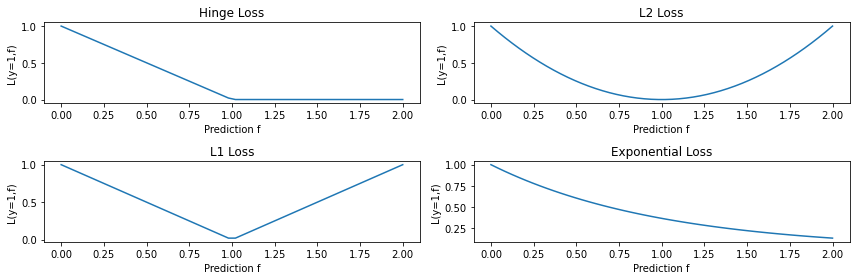

In [5]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 4]

# define the losses for a target of y=1
losses = {
    'Hinge' : lambda f: np.maximum(1 - f, 0),
    'L2': lambda f: (1-f)**2,
    'L1': lambda f: np.abs(f-1),
    'Exponential': lambda f: np.exp(-f)
}

# plot them
f = np.linspace(0, 2)
fig, axes = plt.subplots(2,2)
for ax, (name, loss) in zip(axes.flatten(), losses.items()):
    ax.plot(f, loss(f))
    ax.set_title('%s Loss' % name)
    ax.set_xlabel('Prediction f')
    ax.set_ylabel('L(y=1,f)')
plt.tight_layout()

Notice that the exponential loss very heavily penalizes (i.e., exponentially) misclassified points.
This could potentially be an issue in the presence of outliers or if we have some 'noise' in the labeling process, e.g., points were originally classified by a human annotator with imperfect labeling.

#### Special Case: Adaboost

Adaboost is an instance of forward stagewise additive modeling with the exponential loss.

At each step $t,$ we minimize
$$L_t = \sum_{i=1}^n e^{-y^{(i)}(f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi))} = \sum_{i=1}^n w^{(i)} \exp\left(-y^{(i)}\alpha g(x^{(i)}; \phi)\right) $$
with $w^{(i)} = \exp(-y^{(i)}f_{t-1}(x^{(i)}))$.

We can derive the Adaboost update rules from this equation.

Suppose that $g(y; \phi) \in \{-1,1\}$. With a bit of algebraic manipulations, we get that:
\begin{align*}
L_t & = e^{\alpha} \sum_{y^{(i)} \neq g(x^{(i)})} w^{(i)} + e^{-\alpha} \sum_{y^{(i)} = g(x^{(i)})} w^{(i)} \\
& = (e^{\alpha} - e^{-\alpha}) \sum_{i=1}^n w^{(i)} \mathbb{I}\{{y^{(i)} \neq g(x^{(i)})}\} + e^{-\alpha} \sum_{i=1}^n w^{(i)}.\\
\end{align*}
where $\mathbb{I}\{\cdot\}$ is the indicator function.

From there, we get that:
\begin{align*}
\phi_t & = \arg\min_{\phi} \sum_{i=1}^n w^{(i)} \mathbb{I}\{{y^{(i)} \neq g(x^{(i)}; \phi)}\} \\
\alpha_t & = \log[(1-e_t)/e_t]
\end{align*}
where $e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}\}}$.

These are update rules for Adaboost, and it's not hard to show that the update rule for $w^{(i)}$ is the same as well.

### 16.5.2.2. Squared Loss

Another popular choice of loss is the squared loss, which allows us to derive a principled boosting algorithm for regression (as opposed to the exponential loss which can be used for classification).
We define the squared loss as:
$$ L(y, f) = (y-f)^2. $$

The resulting algorithm is often called L2Boost.
At step $t,$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$ is the residual from the model at time $t-1$.

### 16.5.2.3. Logistic Loss

Another common loss is the logistic loss.
When $\mathcal{Y}=\{-1,1\}$ it is defined as:

$$L(y, f) = \log(1+\exp(-2\cdot y\cdot f)).$$

This looks like the log of the exponential loss; it is less sensitive to outliers since it doesn't penalize large errors as much.

In the context of boosting, we minimize
$$J(\alpha, \phi) = \sum_{i=1}^n \log\left(1+\exp\left(-2y^{(i)}(f_{t-1}(x^{(i)}) + \alpha g(x^{(i)}; \phi)\right)\right).$$

This gives a different weight update compared to Adabost. This algorithm is called LogitBoost.

Let's plot some of these new losses as we did before.

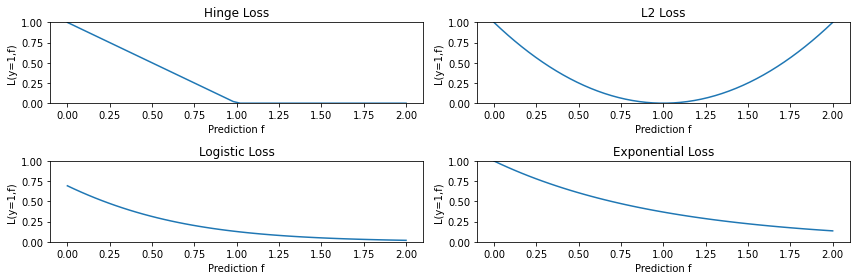

In [6]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 4]

# define the losses for a target of y=1
losses = {
    'Hinge' : lambda f: np.maximum(1 - f, 0),
    'L2': lambda f: (1-f)**2,
    'Logistic': lambda f: np.log(1+np.exp(-2*f)),
    'Exponential': lambda f: np.exp(-f)
}

# plot them
f = np.linspace(0, 2)
fig, axes = plt.subplots(2,2)
for ax, (name, loss) in zip(axes.flatten(), losses.items()):
    ax.plot(f, loss(f))
    ax.set_title('%s Loss' % name)
    ax.set_xlabel('Prediction f')
    ax.set_ylabel('L(y=1,f)')
    ax.set_ylim([0,1])
plt.tight_layout()

To summarize what we have seen for additive models:
* Additive models have the form
$$ f(x) = \sum_{t=1}^T \alpha_t g(x; \phi_t). $$
* These models can be fit using the forward stagewise additive approach.
* This reproduces Adaboost (when using exponential loss) and can be used to derive new boosting-type algorithms that optimize a wide range of objectives that are more robust to outliers and extend beyond classification.

# 16.6. Gradient Boosting

We are now going to see another way of deriving boosting algorithms that is inspired by gradient descent.

## 16.6.1. Limitations of Forward Stagewise Additive Modeling

Forward stagewise additive modeling is not without limitations.
* There may exist other losses for which it is complex to derive boosting-type weight update rules.
* At each step, we may need to solve a costly optimization problem over $\phi_t$.
* Optimizing each $\phi_t$ greedily may cause us to overfit.

## 16.6.2. Motivating Gradient Boosting

Let's start to motivate gradient boosting by taking a new lens to the boosting algorithms we saw above.

Consider, for example, L2Boost, which optimizes the L2 loss
$$ L(y, f) = \frac{1}{2}(y-f)^2. $$

At step $t,$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f_{t-1}(x^{(i)})$ is the residual from the model at time $t-1$.

Observe that the residual is also the derivative of the $L2$ loss 
$$\frac{1}{2}(y^{(i)} - f_{t-1}(x^{(i)}))^2$$
with respect to $f$ at $f_{t-1}(x^{(i)})$:
$$r^{(i)}_t = \frac{\partial L(y^{(i)}, f)}{\partial f} \bigg\rvert_{f = f_{t-1}(x)}$$

Thus, at step $t,$ we are minimizing
$$\sum_{i=1}^n \left( \underbrace{\left(y^{(i)} - f_{t-1}(x^{(i)})\right)}_\text{derivative of $L$ at $f_{t-1}(x^{(i)})$} - g(x^{(i)}; \phi_t)\right)^2. $$

That is, we are trying to select the parameters $\phi_t$ that are closest to the residuals, which we are now viewing as the gradient with respect to $f_{t-1}(x^{(i)})$. 

In the coming sections, we will try to explain why in L2Boost we are fitting the derivatives of the L2 loss?

## 16.6.3. Revisiting Supervised Learning

Let's first recap classical supervised learning, and then contrast it against the gradient boosting approach to which we are building up.

### 16.6.3.1. Supervised Learning: The Model

Recall that a machine learning model is a function
$$ f_\theta : \mathcal{X} \to \mathcal{Y} $$
that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$. 
The model has a $d$-dimensional set of parameters $\theta$:
$$\theta = (\theta_1, \theta_2, ..., \theta_d). $$

### 16.6.3.2. Supervised Learning: The Learning Objective

Intuitively, $f_\theta$ should perform well in expectation on new data $x, y$ sampled from the data distribution $\mathbb{P}$:

$$
J (\theta) = \mathbb{E}_{(x, y)\sim \mathbb{P}} \left[ L\left( y, f_\theta( x \right)) \right] \text{ is "good"}.
$$

Here, $L : \mathcal{X}\times\mathcal{Y} \to \mathbb{R}$ is a performance metric and we take its expectation or average over all the possible samples $ x, y$ from $\mathbb{P}$.

Recall that formally, an expectation $\mathbb{E}_{x\sim {P}} f(x)$ is $\sum_{x \in \mathcal{X}} f(x) P(x)$ if $x$ is discrete and $\int_{x \in \mathcal{X}} f(x) P(x) dx$ if $x$ is continuous.

Intuitively,
$$J(\theta) = \mathbb{E}_{(x, y)\sim \mathbb{P}} \left[ L\left( y, f_\theta( x) \right) \right]
= \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} L\left(y, f_\theta(x) \right) \mathbb{P}(x, y)
$$
is the performance on an *infinite-sized* holdout set, where we have sampled every possible point.


### 16.6.3.3. Supervised Learning: The Optimizer (Gradient Descent)

The gradient $\nabla J(\theta)$ is the $d$-dimensional vector of partial derivatives:

$$ \nabla J (\theta) = \begin{bmatrix}
\frac{\partial J(\theta)}{\partial \theta_1} \\
\frac{\partial J(\theta)}{\partial \theta_2} \\
\vdots \\
\frac{\partial J(\theta)}{\partial \theta_d}
\end{bmatrix}.$$

The $j$-th entry of the vector $\nabla J (\theta)$ is the partial derivative $\frac{\partial J(\theta)}{\partial \theta_j}$ of $J$ with respect to the $j$-th component of $\theta$.

We can optimize $J(\theta)$ using gradient descent via the usual update rule:
$$\theta_t \gets \theta_{t-1} - \alpha_t \nabla J(\theta_{t-1}).$$

However, in practice, we cannot measure
$$\nabla J(\theta) = \mathbb{E}_{( x, y)\sim \mathbb{P}} \left[ \nabla L\left( y, f_\theta( x) \right) \right]$$
on infinite data. 

We substitute $\nabla J(\theta)$ with an approximation $\hat \nabla J(\theta)$ measured on a dataset $\mathcal{D}$ sampled from $\mathbb{P}$:
$$
\hat \nabla J (\theta) = \frac{1}{m} \sum_{i=1}^m \nabla L\left( y^{(i)}, f_\theta( x^{(i)}) \right).
$$
If the number of IID samples $m$ is large, this approximation holds (we call this a Monte Carlo approximation).

## 16.6.4. Supervised Learning Over Functions

Intuitively, the gradient boosting algorithm asks, "what if instead of optimizing over the finite-dimensional parameters $\theta \in \mathbb{R}^d,$ we try optimizing directly over infinite-dimensional functions?"

But what do we mean by "infinite-dimensional functions?"
Letting our model space be the (unrestricted) set of functions $f: \mathcal{X} \to \mathcal{Y},$ each function is an infinite-dimensional *vector* indexed by $x \in \mathcal{X}$:
$$ f = \begin{bmatrix}
\vdots \\
f(x) \\
\vdots
\end{bmatrix}.$$
The $x$-th component of the vector $f$ is $f(x)$.
So rather than uniquely characterizing a function by some finite dimensional vector of parameters, a point in function space can be uniquely characterized by the values that it takes on every possible input, of which there can be infinitely many.
It's as if we choose infinite parameters $\theta=(..., f(x), ...)$ that specify function values, and we optimize over that.

#### The Learning Objective

Our learning objective $J(f)$ is now defined over $f$.
Although the form of the objective will be equivalent to the standard supervised learning setup we recalled above, we can think of optimizing $J$ over a "very high-dimensional" (potentially infinite) vector of "parameters" $f$.

Keep in mind that $f$ should perform well in expectation on new data $x, y$ sampled from the data distribution $\mathbb{P}$:

$$
J (f) = \mathbb{E}_{( x,  y)\sim \mathbb{P}} \left[ L\left( y, f( x \right)) \right] \text{ is "good"}.
$$

#### Functional Gradients

We would like to again optimize $J(f)$ using gradient descent:

$$\min_f J(f) = \min_f \mathbb{E}_{(x, y)\sim \mathbb{P}} \left[ L\left(y, f(x \right)) \right].$$

We may define the functional gradient of this loss at $f$ as an infinite-dimensional vector $\nabla J(f) : \mathcal{X} \to \mathbb{R}$ "indexed" by $x$:
$$ \nabla J (f) = \begin{bmatrix}
\vdots \\
\frac{\partial J(f)}{\partial f(x)} \\
\vdots \\
\end{bmatrix}.$$

Let's compare the parametric and the functional gradients.

* The parametric gradient $\nabla J(\theta) \in \mathbb{R}^d$ is a vector of the same shape as $\theta  \in \mathbb{R}^d$. Both $\nabla J(\theta)$ and $\theta$ are indexed by $j=1,2,...,d$.

* The functional gradient $\nabla J(f) : \mathcal{X} \to \mathbb{R}$ is a vector of the same shape as $f : \mathcal{X} \to \mathbb{R}$. Both $\nabla J(f)$ and $f$ are "indexed" by $x \in \mathcal{X}$.

* The parametric gradient $\nabla J(\theta)$ at $\theta = \theta_0$ tells us how to modify $\theta_0$ in order to further decrease the objective $J$ starting from $J(\theta_0)$.

* The functional gradient $\nabla J(f)$ at $f = f_0$ tells us how to modify $f_0$ in order to further decrease the objective $J$ starting from $J(f_0)$.
We can think of this as the functional gradient telling us how to change the output of $f_0$ for each possible input in order to better optimize our objective.

This is best understood via a picture.

<center><img width=100% src="../slides/img/functional_gradient.png"></center>

The functional gradient is a function that tells us how much we "move" $f(x)$ at each point $x$.
Given a good step size, the resulting new function will be closer to minimizing $J$.

Recall that we are taking the perspective that $f$ is a vector indexed by $x.$
Thus the $x$-th entry of the vector $\nabla J (f)$ is the partial derivative $\frac{\partial J(f)}{\partial f(x)}$ of $J$ with respect to $f(x)$, the $x$-th component of $f$.
$$
\frac{\partial J(f)}{\partial f(x)} = \frac{\partial}{\partial f(x)} \left( \mathbb{E}_{( x,  y)\sim \mathbb{P}} \left[ L\left( y, f( x \right)) \right] \right) = \frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f=f(x)}
$$

So the functional gradient is
$$ \nabla J (f) = \begin{bmatrix}
\vdots \\
\frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f=f(x)} \\
\vdots \\
\end{bmatrix}.$$
This is an infinite-dimensional vector indexed by $x$.

#### Functional Gradient Descent

Previously, we optimized $J(\theta)$ using gradient descent via the update rule:
$$\theta_t \gets \theta_{t-1} - \alpha_t \nabla J(\theta_{t-1})$$

We can now optimize our objective using gradient descent in functional space via the same update:
$$f_t \gets f_{t-1} - \alpha_t \nabla J(f_{t-1}).$$

After $T$ steps of $f_t \gets f_{t-1} - \alpha_t \nabla J(f_{t-1})$, we get a model of the form
$$f_T = f_0-\sum_{t=0}^{T-1} \alpha_t \nabla J(f_{t})$$

#### The Challenge of Supervised Learning Over Functions

After $T$ steps of $f_t \gets f_{t-1} - \alpha_t \nabla J(f_{t-1})$, we get a model of the form
$$f_T = f_0-\sum_{t=0}^{T-1} \alpha_t \nabla J(f_{t})$$

Recall that each $\nabla J(f_{t})$ is a function of $x.$
Therefore $f_T$ is a function of $x$ as well, and as a function that is found through gradient descent, $f_T$ will minimize $J.$

But recall as well that in the standard supervised learning approach that we reviewed above, we were not able to compute $\nabla J(\theta) = \mathbb{E}_{( x, y)\sim \mathbb{P}} \left[ \nabla L\left( y, f_\theta( x) \right) \right]$
on infinite data and instead we used:
$$
\hat \nabla J (\theta) = \frac{1}{m} \sum_{i=1}^m \nabla L\left( y^{(i)}, f_\theta( x^{(i)}) \right).
$$

In the case of functional gradients, we also need to find an approximation $\hat \nabla J(f)$:
$$
\nabla J(f) (x) = \frac{\partial J(f)}{\partial f(x)} = \frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f=f(x)}
$$

This is more challenging than before:
* $\nabla J(f) (x) = \frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f=f(x)}$ is not an expectation so we can't approximate it with an average in the data.

* $\nabla J (f)$ is a function that we need to "learn" from $\mathcal{D}$. (We will use supervised learning for this!)

* We cannot represent $\nabla J(f)$ because it's a general function.
* We cannot measure $\nabla J(f)$ at each $x$ (only at $n$ training points).
* Even if we could, the problem would be too unconstrained and generally intractable to optimize.

## 16.6.5. Modeling Functional Gradients

We will address the above problem by learning a *model* of gradients.

* In supervised learning, we only have access to $n$ data points that describe the true $\mathcal{X} \to \mathcal{Y}$ mapping (call it $f^*$).
* We learn a *model* $f_\theta:\mathcal{X} \to \mathcal{Y}$ from a function class $\mathcal{M}$ to approximate $f^*$.
* The model extrapolates beyond the training set. Given enough datapoints, $f_\theta$ learns a true mapping.

We can apply the same idea to gradients, learning $\nabla J(f).$ 
* We search for a model $g_{\theta_t} : \mathcal{X} \to R$ within a more restricted function class $\mathcal{M}$ that can approximate the functional gradient $\nabla J(f_t)$.
\begin{align*}
g_{\theta_t} \in \mathcal{M} & & g_{\theta_t} \approx \nabla J(f_t)
\end{align*}
* The model extrapolates beyond the training set. Given enough datapoints, $g_{\theta_t}$ learns $\nabla J(f_t)$.
* Think of $g_{\theta_t}$ as the *projection* of $\nabla J(f_t)$ onto the function class $\mathcal{M}.$

Functional descent will then have the form:
$$\underbrace{f_t(x)}_\text{new function} \gets \underbrace{f_{t-1}(x) - \alpha g_{\theta_{t-1}}(x)}_\text{old function - gradient step}.$$
If $g$ generalizes, this approximates $f_t \gets f_{t-1} - \alpha \nabla J(f_{t-1}).$

## 16.6.6. Fitting Functional Gradients

In practice, what does it mean to approximate a functional gradient $g \approx \nabla J(f)m$?
We can use standard supervised learning. Suppose we have a fixed function $f$ and we want to estimate the functional gradient of $L$
$$\frac{\partial L(\text{y}, f)}{\partial f} \bigg\rvert_{f = f(x)}.$$
at any $x \in \mathcal{X}$

**Step 1:** We define a loss $L_g$ (e.g., L2 loss) to measure how well $g \approx \nabla J(f)$.

**Step 2:** We compute $\nabla J(f)$ on the training dataset:
$$\mathcal{D}_g = \left\{ \left(x^{(i)}, \underbrace{\frac{\partial L(y^{(i)}, f)}{\partial f} \bigg\rvert_{f = f(x^{(i)})}}_\text{functional derivative $\nabla_f J(f)_i$ at $f(x^{(i)})$} \right), i=1,2,\ldots,n \right\} $$

**Step 3:** We train a model $g : \mathcal{X} \to \mathbb{R}$ on $\mathcal{D}_g$ to predict functional gradients at any $x$:
$$ g(x) \approx \frac{\partial L(\text{y}, f)}{\partial f} \bigg\rvert_{f = f_0(x)}.$$

## 16.6.7. Gradient Boosting

We now have the motivation and background needed to define gradient boosting.
Gradient boosting is a procedure that performs functional gradient descent with approximate gradients.

Start with $f(x) = 0$. Then, at each step $t>1$:

**Step 1:** Create a training dataset $\mathcal{D}_g$ and fit $g_t(x^{(i)})$ using loss $L_g$:
$$ g_t(x) \approx \frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f = f_{t-1}(x)}.$$

**Step 2:** Take a step of gradient descent using approximate gradients with step $\alpha_t$:
$$f_t(x) = f_{t-1}(x) - \alpha_t \cdot g_t(x).$$

## 16.6.8. Interpreting Gradient Boosting

Notice how after $T$ steps we get an additive model of the form
$$ f(x) = \sum_{t=1}^T \alpha_t g_t(x). $$
This looks like the output of a boosting algorithm!

However, unlike before for forward stagewise additive models:
* This works for any differentiable loss $L$.
* It does not require any mathematical derivations for new $L$.

## 16.6.9. Returning to L2 Boosting

To better highlight the connections between boosting and gradient boosting, let's return to the example of L2Boost, which optimizes the L2 loss
$$ L(y, f) = \frac{1}{2}(y-f)^2$$

At step $t,$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f_{t-1}(x^{(i)})$ is the residual from the model at time $t-1$.

Observe that the residual
$$r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$$
is also the gradient of the $L2$ loss with respect to $f$ at $f(x^{(i)})$
$$r^{(i)}_t = \frac{\partial L(y^{(i)}, f)}{\partial f} \bigg\rvert_{f = f_{t-1}(x)}$$

This answers our question from above as to "why in L2Boost we are fitting the derivatives of the L2 loss?"
The reason is that we are finding an approximation $g(\cdot; \phi)$ to $\nabla J(f)$ and to do so we are minimize the square loss between $\nabla J(f)(x^{(i)}) = r_t^{(i)}$ and $g(x^{(i)}; \phi)$ at our $n$ training points.

Many boosting methods are special cases of gradient boosting in this way.

## 16.6.10. Losses for Additive Models vs. Gradient Boosting

We have seen several losses that can be used with the forward stagewise additive approach.
* The exponential loss $L(y,f) = \exp(-yf)$ gives us Adaboost.
* The log-loss $L(y,f) = \log(1+\exp(-2yf))$ is more robust to outliers.
* The squared loss $L(y,f) = (y-f)^2$ can be used for regression.

Gradient boosting can optimize a wider range of losses.

* Regression losses:
    * L2, L1, and Huber (L1/L2 interpolation) losses.
    * Quantile loss: estimates quantiles of distribution of $p(y|x)$.
* Classification losses:
    * Log-loss, softmax loss, exponential loss, negative binomial likelihood, etc.

When using gradient boosting these additional facts are useful:
* We most often use small decision trees as the learner $g_t$. Thus, input preprocessing is minimal.
* We can regularize by controlling tree size, step size $\alpha$, and using *early stopping*.
* We can scale-up gradient boosting to big data by sub-sampling data at each iteration (a form of *stochastic* gradient descent).

## 16.6.11. Algorithm: Gradient Boosting

As with the other algorithms we've seen, we can now present the algorithmic components for gradient boosting.

* __Type__: Supervised learning (classification and regression).
* __Model family__: Ensembles of weak learners (often decision trees).
* __Objective function__: Any differentiable loss function.
* __Optimizer__: Gradient descent in functional space. Weak learner uses its own optimizer.
* __Probabilistic interpretation__: None in general; certain losses may have one.

## 16.6.12. Gradient Boosting: An Example

Let's now try running Gradient Boosted Decision Trees (GBDT) on a small regression dataset.

First we create the dataset. Our values come from a non-linear function $f(x)$ plus some noise.

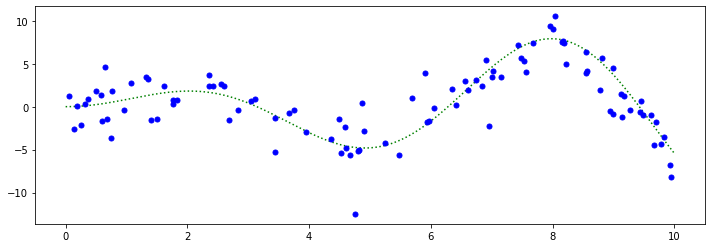

In [7]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Create dataset
f = lambda x: x * np.sin(x)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Visualize it
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations');

Next, we train a GBDT regressor, using the `GradientBoostingRegressor` class from `sklearn`.

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.95
clf = GradientBoostingRegressor(loss='squared_error', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.95, min_samples_leaf=9, min_samples_split=9,
                          n_estimators=250)

We may now visualize its predictions

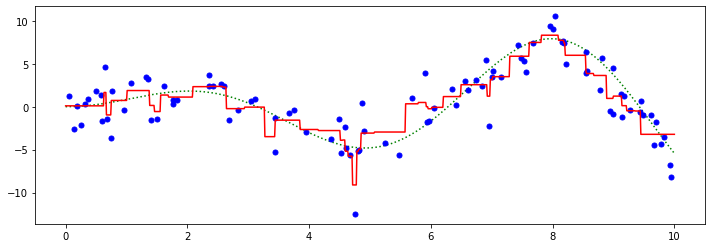

In [9]:
y_pred = clf.predict(xx)
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction');

## 16.6.14. Pros and Cons of Gradient Boosting

Gradient boosted decision trees (GBTs) are one of the best off-the-shelf ML algorithms that exist, often on par with deep learning.
* Attain state-of-the-art performance. GBTs have won the most Kaggle competitions. 
* Require little data preprocessing and tuning.
* Work with any objective, including probabilistic ones.

Their main limitations are:
* GBTs don't work with unstructured data like images, audio.
* Implementations are not as flexible as modern neural net libraries.